In [1]:
import sys
sys.path.append("../../src")
import os
import datetime
import pandas as pd
import numpy as np
from wsindy_utils import library_size
from training_wsindy import train_network
import tensorflow.compat.v1 as tf

tf.compat.v1.disable_v2_behavior()
from time import time
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import pickle 
import subprocess as sp

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# specify which GPU to use
config = tf.ConfigProto(log_device_placement=False, gpu_options=tf.GPUOptions(allow_growth=True,
                                                                              visible_device_list='0'))

## Load data

In [3]:
# load initial training dataset
sys.path.append("..")
#amp_train = np.linspace(0.7,0.9,2)
#width_train = np.linspace(0.9,1.1,2)
amp_train = np.array([0.7])
width_train = np.array([0.9])
num_train = amp_train.size * width_train.size # initial number of training data

tstop = 1.0
# train_data = pickle.load(open(f"/usr/workspace/he10/data/1DBurgerEqn/local1_A{amp_train[0]:.2f}_W{width_train[0]:.2f}.p", "rb"))
train_data = pickle.load(open(f"/usr/workspace/he10/data/1DBurgerEqn/noisy/local1_A{amp_train[0]:.2f}_W{width_train[0]:.2f}_10pc_noise.p", "rb"))
#train_data = pickle.load(open(f"./data/local{num_train}.p", "rb")) # A:[0.7,0.9], W:[0.9,1.1]
num_wsindy = len(train_data['data'])
input_dim = train_data['data'][0]['x'].shape[1]

nt = train_data['data'][0]['x'].shape[0]
nx = train_data['data'][0]['x'].shape[1]
for i in range(num_wsindy):
    print(f"case {i}: params: {train_data['param'][i]}, x shape: {train_data['data'][i]['x'].shape}")

# load dataset of discrete parameter space for greedy sampling
#amp_test = np.linspace(0.7,0.9,21)
#width_test = np.linspace(0.9,1.1,21)
amp_test = np.array([0.7])
width_test = np.array([0.9])
num_test = amp_test.size * width_test.size # number of cases in the discrete parameter space
#est_data = pickle.load(open(f"./data/local{num_test}.p", "rb")) # A:[0.7,0.9], W:[0.9,1.1]
test_data = pickle.load(open(f"/usr/workspace/he10/data/1DBurgerEqn/local1_A{amp_test[0]:.2f}_W{width_test[0]:.2f}.p", "rb"))

case 0: params: [0.7 0.9], x shape: (1001, 1001)


In [4]:
grid1, grid2 = np.meshgrid(amp_train, width_train)
train_param = np.hstack((grid1.flatten().reshape(-1,1), grid2.flatten().reshape(-1,1)))
grid1, grid2 = np.meshgrid(amp_test, width_test)
test_param = np.hstack((grid1.flatten().reshape(-1,1), grid2.flatten().reshape(-1,1)))

train_idx = []
for i in range(num_test):
    for j in range(num_train):
        if np.abs(test_param[i,0]-train_param[j,0]) < 1e-8 and \
        np.abs(test_param[i,1]-train_param[j,1]) < 1e-8:
            train_idx.append(i)
print(train_idx)

[0]


## Set up model and training parameters

In [5]:
params = {}

params['L'] = 80
params['seed'] = 1 # random seed
params['config'] = config
params['num_wsindy'] = num_wsindy
params['param'] = train_data['param']
params['train_idx'] = train_idx
params['input_dim'] = input_dim
params['latent_dim'] = 5
params['poly_order'] = 1
params['include_sine'] = False
params['include_cosine'] = False
params['include_costant'] = True
params['library_dim'] = library_size(params['latent_dim'], params['poly_order'], 
                                     params['include_sine'], params['include_cosine'], 
                                     params['include_costant'])

# sequential thresholding parameters
params['sequential_thresholding'] = False
params['coefficient_threshold'] = 0.1
params['threshold_frequency'] = 500
params['coefficient_mask'] = np.ones((params['library_dim'], params['latent_dim']))
params['coefficient_initialization'] = 'constant'

# loss function weighting
params['loss_weight_decoder'] = 1.0
params['loss_weight_wsindy_x'] = 1
params['loss_weight_wsindy_z'] = 1
params['loss_weight_wsindy_regularization'] = 1e-5
params['diff'] = 'symb' # 'symb': symbolic diff (only for fully connected Autoencoder), 'auto': automatic diff
params['activation'] = 'relu'
params['widths'] = [100]

# training parameters
params['epoch_size'] = train_data['data'][0]['x'].shape[0]
num_batch = 1
params['batch_size'] = (params['epoch_size'] + 2 * (num_batch-1) * params['L']) // num_batch # for N batches: (epoch_size + 2*(N-1)*L)/N
params['batch_overlap'] = 2*params['L']
params['learning_rate'] = 1e-3
params['fig_path'] = os.getcwd() + '/fig/nDI1/'
if not os.path.exists(params['fig_path']):
    os.makedirs(params['fig_path'])
params['print_progress'] = True
params['print_frequency'] = 100
params['save_frequency'] = 10000

# training epochs
params['max_epochs'] = 10000  # max number of training epochs

# Greedy sampling algorithm
params['update_epoch'] = 200000 # Greedy sampling frequency
params['tol'] = 0.001         # initial tolerance of the maximum error indicator in the parameter space; it will be updated during training using the prescribed `adaptive` method
params['tol2'] = 2            # initial tolerance of the maximum relative error in the parameter space
params['wsindy_max'] = None      # max number of local DIs; if tolerance is used as a termination criterior, set it as None
params['convex_knn'] = 1      # the number nearest local DIs used for convex interpolation during Greedy sampling
params['test_data'] = test_data # dataset of the discrete parameter space
params['test_param'] = np.hstack((amp_test.reshape(-1,1), width_test.reshape(-1,1)))    # parameters of the discrete parameter space
params['num_test'] = num_test # the number of parameter cases of the discrete parameter space
params['coeff_exist'] = False # whether to initialize model coefficients with pescribed values, set as False
params['retrain'] = False     # whether to retrain the model; set as False for training a new model

# Error indicator:
# 1: max relative error (if test data is available); 
# 2: residual norm for 1D Burgers eqn; 
# 3: residual norm for 2D Burgers eqn; 
# 4: residual norm for time dependent heat conduction (MFEM example 16); 
# 5: residual norm for radial advection (MFEM example 9)
params['err_type'] = 2                            
params['subsize'] = int(0.5 * num_test) # initial random subset size, the number of randomly selected cases for Greedy sampling
params['subsize_max'] = 80              # maximum random subset size in percentage

# Adaptive approach for tol of error indicator:
# 'mean': use mean ratios between error indicator and max relative errors
# 'reg_mean': use linear regression line
# 'reg_max': use linear regression line shifted by std to upper bound
# 'reg_min': use linear regression line shifted by std to lower bound, more conservative
params['adaptive'] = 'reg_max'                      

# PDE parameters
params['pde'] = {}
params['pde']['nx'] = nx
params['pde']['nt'] = nt
params['pde']['tstop'] = tstop
params['pde']['dt'] = tstop / (nt-1)

In [6]:
if params['retrain']:
    save_name = 'burger_2021_11_26_10_02_50'
    params = pickle.load(open(params['fig_path'] + save_name + '_params.pkl', 'rb'))
    params['retrain'] = True
    params['coeff_exist'] = True  # flag to indicate whether to initialize model coefficients with pescribed values
    params['save_name'] = save_name
    params['max_epochs'] = 5000
    params['update_epoch'] = 5000
    params['save_frequency'] = 1000
    
    for i in params['train_idx'][4:]:
        train_data['data'].append(test_data['data'][i])
        train_data['param'].append(test_data['param'][i])

## Training

Instructions for updating:
Use `tf.cast` instead.
* Evaluating
  Time: 1.02 s, Case: [0.7 0.9], Tol: 0.00100, Max Error: 4.091239
Epoch 0
  train loss: 1.3236e-01, decoder: 1.3082e-01, wsindy-x: 1.8645e-04, wsindy-z: 1.3395e-03, wsindy-reg: 1.0000
Epoch 100
  train loss: 2.6389e-03, decoder: 2.4505e-03, wsindy-x: 1.7468e-04, wsindy-z: 3.7073e-06, wsindy-reg: 0.9997
Epoch 200
  train loss: 2.4139e-03, decoder: 2.2158e-03, wsindy-x: 1.7414e-04, wsindy-z: 1.3987e-05, wsindy-reg: 0.9991
Epoch 300
  train loss: 1.5303e-03, decoder: 1.3444e-03, wsindy-x: 1.7085e-04, wsindy-z: 5.0768e-06, wsindy-reg: 0.9972
Epoch 400
  train loss: 1.5106e-03, decoder: 1.3285e-03, wsindy-x: 1.7077e-04, wsindy-z: 1.4035e-06, wsindy-reg: 0.9962
Epoch 500
  train loss: 1.5080e-03, decoder: 1.3263e-03, wsindy-x: 1.7076e-04, wsindy-z: 9.4546e-07, wsindy-reg: 0.9952
Epoch 600
  train loss: 1.5050e-03, decoder: 1.3235e-03, wsindy-x: 1.7073e-04, wsindy-z: 7.6826e-07, wsindy-reg: 0.9940
Epoch 700
  train loss: 1.4964e-

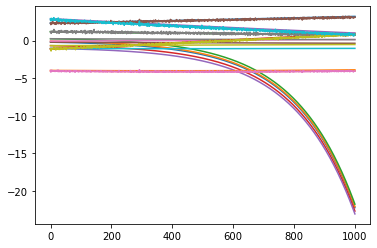

In [7]:
df = pd.DataFrame()
timer = []
timer.append(time())

if not params['retrain']:
    params['save_name'] = 'burger_' + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
tf.reset_default_graph()
results_dict = train_network(train_data, params)
df = df.append({**results_dict, **params}, ignore_index=True)
    
timer.append(time())
print(f'training time: {(timer[-1]-timer[0])/60:.2f} mins, {(timer[-1]-timer[0])/3600:.2f} hours')

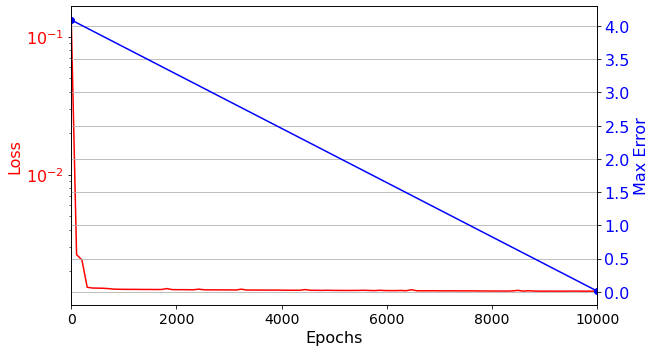

In [8]:
# history of validation loss
train_loss = np.array(df['training_losses'][0]).squeeze()
test_loss = np.array(df['testing_losses'][0]).squeeze()

fig, ax1 = plt.subplots(figsize=(9,5))
xt = np.linspace(1,df['epoch_count'],train_loss.shape[0])
ax1.plot(xt, train_loss[:,0], 'r', label='Train')
ax1.set_yscale('log')
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax1.set_xlabel('Epochs', fontsize=16)
ax1.set_ylabel('Loss', color='r', fontsize=16)
ax1.set_xlim(0, params['epoch_count'])
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
xt = np.linspace(1,df['epoch_count'],test_loss.shape[0])
ax2.plot(xt, test_loss, 'b-o', label='Val')
ax2.set_ylabel('Max Error', color='b', fontsize=16)
ax2.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='y', labelcolor='b')

plt.grid()
plt.tight_layout()
plt.savefig(f"{params['fig_path']}/loss.png")